In [8]:
import time
from functools import partial
from copy import deepcopy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn.functional as F

from torch_geometric.utils import add_self_loops
from torch_geometric.nn import MLP, GCN

from data import get_sbm
from utils import get_results_path
from visualization import get_box_plot_coords


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on device: {}".format(device))


Running on device: cuda


In [10]:
# Hyperparameters
max_epochs = 70
hidden_channels = 16
runs = 50
max_num_layers = 6

# Dataset parameters
cluster_std = 0.4
n_features = 16
num_classes = 10
centers = torch.eye(num_classes)
num_nodes_per_class = 100
num_nodes = num_nodes_per_class * num_classes
block_sizes = torch.tensor([num_nodes_per_class] * num_classes)


In [11]:
GNNs = [("MLP", MLP), ("GCN", partial(GCN, add_self_loops=False))]


In [12]:
df = pd.DataFrame()


In [13]:
pbar = trange(runs)
for i in pbar:
    for edge_num_self, edge_num_other in [
        (6, 3),
        (6, 6),
        (3, 6),
        (1, 9),
    ]:
        name = f"p_ii={edge_num_self}/100, p_ij={edge_num_other}/100"
        pbar.set_postfix_str(name)

        # Generate a probability matrix for the SBM
        prob_matrix = torch.full(
            (num_classes, num_classes), edge_num_other / (num_nodes - 100)
        )
        edge_prob_self = edge_num_self / block_sizes
        edge_probs = (prob_matrix * (1 - torch.eye(num_classes))) + torch.diag(
            edge_prob_self
        )
        # Generate a Stochastic Block Model
        orig_data = get_sbm(
            block_sizes=block_sizes,
            edge_probs=edge_probs,
            centers=centers,
            cluster_std=cluster_std,
            n_features=n_features,
            seed=i,
        )

        for num_layers in range(1, max_num_layers + 1):
            for GNN_name, GNN_model in GNNs:
                for self_loops in [False, True]:
                    start_time = time.time()
                    data = deepcopy(orig_data).to(device)

                    model = GNN_model(
                        in_channels=data.x.shape[1],
                        hidden_channels=hidden_channels,
                        out_channels=data.y.max().item() + 1,
                        num_layers=num_layers,
                    ).to(device)

                    if self_loops:
                        data.edge_index = add_self_loops(
                            data.edge_index, num_nodes=data.num_nodes
                        )[0]

                    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

                    model.train()
                    for epoch in range(max_epochs):
                        optimizer.zero_grad()
                        if GNN_name == "MLP":
                            out = model(data.x)
                        else:
                            out = model(data.x, data.edge_index)

                        loss = F.cross_entropy(
                            out[data.train_mask], data.y[data.train_mask]
                        )

                        loss.backward()
                        optimizer.step()

                    model.eval()
                    if GNN_name == "MLP":
                        out = model(data.x)
                    else:
                        out = model(data.x, data.edge_index)

                    train_acc = (
                        out[data.train_mask]
                        .argmax(-1)
                        .eq(data.y[data.train_mask])
                        .sum()
                        .item()
                        / data.train_mask.sum().item()
                    )
                    test_acc = (
                        out[data.test_mask]
                        .argmax(-1)
                        .eq(data.y[data.test_mask])
                        .sum()
                        .item()
                        / data.test_mask.sum().item()
                    )

                    df = pd.concat(
                        [
                            df,
                            pd.DataFrame(
                                {
                                    "model": GNN_name,
                                    "dataset": name,
                                    "num_layers": num_layers,
                                    "self_loops": self_loops,
                                    "run": i,
                                    "train_loss": loss.item(),
                                    "train_acc": train_acc,
                                    "test_acc": test_acc,
                                    "time": time.time() - start_time,
                                },
                                index=[0],
                            ),
                        ],
                        ignore_index=True,
                    )

    df.to_csv(get_results_path() / "synthetic.csv")


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

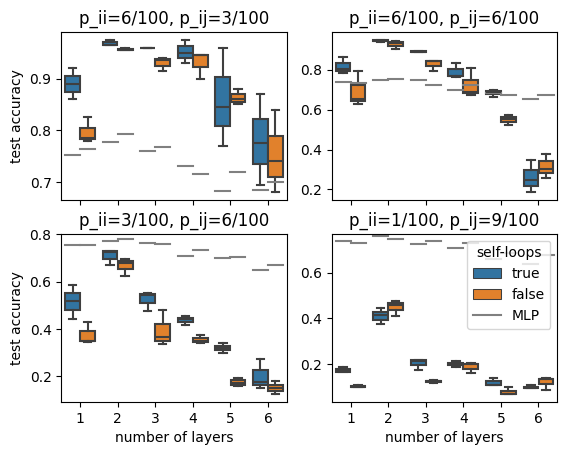

In [14]:
axs = plt.subplots(df["dataset"].nunique() // 2, 2, sharex=True, sharey=False)[
    1
].flatten()

for i, (ax, dataset) in enumerate(zip(axs, df["dataset"].unique())):
    # Show the average GCN accuracy per layer using boxplots grouped by self-loops
    GCN_df = df[(df["dataset"] == dataset) & (df["model"] == "GCN")]
    sns.boxplot(
        x="num_layers",
        y="test_acc",
        data=GCN_df,
        ax=ax,
        hue="self_loops",
        hue_order=[True, False],
    )

    # Add the MLP accuracy per layer as a baseline
    MLP_df = df[(df["dataset"] == dataset) & (df["model"] == "MLP")]
    x_ls, x_rs = get_box_plot_coords(n_classes=max_num_layers, n_hue=2)
    for y, x_l, x_r in zip(
        MLP_df.groupby(["num_layers", "self_loops"], sort=False)["test_acc"]
        .mean()
        .values,
        x_ls,
        x_rs,
    ):
        mlp = ax.axhline(y=y, xmin=x_l, xmax=x_r, ls="-", color="grey")

    # Set the title, legend and axis labels
    ax.set_title(dataset)
    if i == 3:
        legend = ax.legend()
        handles, labels = legend.legend_handles, [
            text.get_text() for text in legend.get_texts()
        ]
        labels = [label.lower() for label in labels]
        ax.legend(
            handles + [mlp],
            labels + ["MLP"],
            loc="upper right",
            title="self-loops",
        )
    else:
        ax.legend().remove()
    if i % 2 == 0:
        ax.set_ylabel(r"test accuracy")
    else:
        ax.set_ylabel("")
    if i >= 2:
        ax.set_xlabel(r"number of layers")
    else:
        ax.set_xlabel("")

plt.savefig(get_results_path() / "synthetic.pdf", bbox_inches="tight")
